In [6]:
import sys
import os
sys.path.append(os.getcwd()+"/Sklearn-neat")

from matplotlib import pyplot as plt
# from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from neuro_evolution import NEATClassifier
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
import neat
import numpy as np
import cv2
import logging
from sklearn.model_selection import StratifiedShuffleSplit
from io import StringIO 
import re
import glob

In [2]:
neat.math_util.mean([5,2,4])

Works :)


3.6666666666666665

In [3]:
class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

X = np.append(x_train,x_test).reshape(60000,32,32,3)
y = np.append(y_train,y_test).reshape(60000,1)

assert X.shape == (60000, 32, 32, 3)
assert y.shape == (60000, 1)

In [5]:

#Transform (50000, 32, 32, 3) to (50000, 32, 32) with grayscaling.
# x_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_train])
# x_test = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_test])

#Preprocess the data
X = X.astype('float32')
X /= 255

In [7]:
sss = StratifiedShuffleSplit(n_splits=5, 
                             test_size=0.0002, 
                             train_size=0.001, 
                             random_state=0)

for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [17432  5066 25917 31434  5889  7087 56127 46497 54838 13118 33782 28512
 38014 53028 32631 13793 49293  2457 44180 39885 40153 44035 46225 43338
 33202 39482  2128 54543 37306 36690 44010  8644 26694 46600 44534 49231
 53793 26659  2884 51151 35761 18915 32094 57723 31921   315 47947 57014
  9803 51523 23558  7921 25500  1995 36438 29828 32793 48012 21576 40350] TEST: [32677 25499 13322 54421 37416 13956 53315  4011 32347 59734 57975 53847]
TRAIN: [47952 57896 50782  8625 57713  3980 54866 50276  3061   266 52340 26388
 44081  1067  2839  9941 18845 38520 47962 12967  1116 49217  8068  2766
  8846 11764 49442 27592 24336 46490 13274 38542 12250 42032 13748 15962
 40459 15218 17681 53585 45268 38518 31407 52137 29921 49630 32317 32411
 45431 31895 12326 11939 12721 16005 18455 18126 52302  9188 51270 55759] TEST: [35533 22018 15851 54629 16774 43213  3000 32448 10611 28107  9847 49370]
TRAIN: [32519 26734 17164 27409 56918  5862  5960 44476 51532 26315 49076 27278
 23669 33760 3

In [8]:
print(X_train.shape)
print(y_train.shape)

print("---")

print(X_test.shape)
print(y_test.shape)

(60, 32, 32, 3)
(60, 1)
---
(12, 32, 32, 3)
(12, 1)


In [9]:
def find_metric_in_output(output, string):    
    result = re.findall(r"\b"+string+r" ([0-9]+\.[0-9]+)\b", str(output))
    result = np.array(result).astype('float')
    result = result[0]
    
    return result

X_train_fl = X_train.reshape((X_train.shape[0], -1))
X_test_fl = X_test.reshape((X_test.shape[0], -1))

clf = NEATClassifier(number_of_generations=1,
                     fitness_threshold=0.1,
                     pop_size=5)

results = {}
best_fitness = 0

for i in range(2):
    print("*** Running generation {} ***".format(str(i)))
    with Capturing() as output:
        neat_genome = clf.fit(X_train_fl, y_train.ravel())
        
    curr_fitness = find_metric_in_output(output, "Fitness:")
    curr_popavgfit = find_metric_in_output(output, "Population's average fitness:")
    curr_stdev = find_metric_in_output(output, "stdev:")
        
    print("Fitness: {}".format(curr_fitness))
    print("Population's average fitness: {}".format(curr_popavgfit))
    print("Standard deviation: {}".format(curr_stdev))

    print("---")
    if curr_fitness > best_fitness:
        best_fitness = curr_fitness
        
    print("Best fitness: {}".format(best_fitness))
    
    results[i] = {
        "fitness":curr_fitness,
        "pop_avg_fitness":curr_popavgfit,
        "stdev":curr_stdev   
    }

    print("---\n")

*** Running generation 0 ***
Fitness: 0.1
Population's average fitness: 0.06667
Standard deviation: 0.02789
---
Best fitness: 0.1
---

*** Running generation 1 ***
Fitness: 0.11666666666666667
Population's average fitness: 0.1
Standard deviation: 0.02582
---
Best fitness: 0.11666666666666667
---



In [10]:
y_pred = neat_genome.predict(X_test_fl)

In [11]:
print(classification_report(y_test.ravel(), y_pred.ravel()))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       2.0
           1       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       1.0
           5       0.00      0.00      0.00       1.0
           6       0.00      0.00      0.00       1.0
           7       0.00      0.00      0.00       1.0
           8       0.00      0.00      0.00       2.0
           9       0.00      0.00      0.00       1.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0



/home/sram/radboud-naco-project/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sram/radboud-naco-project/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sram/radboud-naco-project/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [12]:
results.items()

dict_items([(0, {'fitness': 0.1, 'pop_avg_fitness': 0.06667, 'stdev': 0.02789}), (1, {'fitness': 0.11666666666666667, 'pop_avg_fitness': 0.1, 'stdev': 0.02582})])

[]

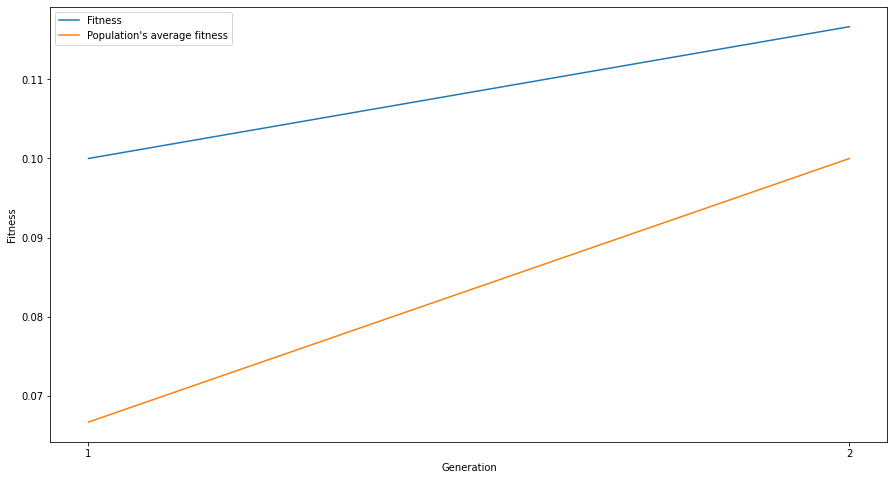

In [14]:
fitness = [i['fitness'] for i in results.values()]
pop_avg_fitness = [i['pop_avg_fitness'] for i in results.values()]

fig,ax = plt.subplots(figsize=(15,8))

plt.plot(np.linspace(1,len(fitness),len(fitness)),
         fitness,
         label="Fitness")
plt.plot(np.linspace(1,len(pop_avg_fitness),len(pop_avg_fitness)),
         pop_avg_fitness,
         label="Population's average fitness")

plt.xlabel("Generation")
plt.ylabel("Fitness")

plt.legend()

plt.xticks(np.linspace(1,len(fitness),len(pop_avg_fitness)))

plt.savefig("../figures/fitness.png")

plt.plot()

[]

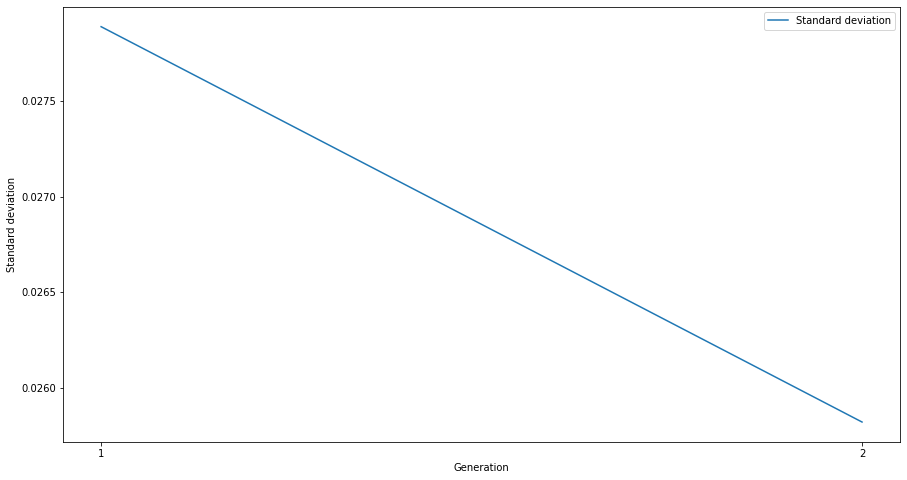

In [15]:
stdev = [i['stdev'] for i in results.values()]

fig,ax = plt.subplots(figsize=(15,8))

plt.plot(np.linspace(1,len(stdev),len(stdev)),
         stdev,
         label="Standard deviation")

plt.xlabel("Generation")
plt.ylabel("Standard deviation")

plt.legend()

plt.xticks(np.linspace(1,len(stdev),len(stdev)))

plt.savefig("../figures/stdev.png")

plt.plot()